# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:oracle.run2_limited",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "n_shot": 3,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_mag"],
    "x_transforms_target": ["unit_mag"],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_mag']
x_transforms_target ['unit_mag']
Average magnitude, source: 1.0
Average power, source: 1.2461352


Average magnitude, target: 1.0
Average power, target: 1.2650003


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 2520], examples_per_second: 128.3243, train_label_loss: 2.7755, 


epoch: 1, [batch: 252 / 2520], examples_per_second: 3185.7953, train_label_loss: 2.8058, 


epoch: 1, [batch: 504 / 2520], examples_per_second: 3185.4389, train_label_loss: 2.3470, 


epoch: 1, [batch: 756 / 2520], examples_per_second: 3218.4284, train_label_loss: 1.7428, 


epoch: 1, [batch: 1008 / 2520], examples_per_second: 3178.7821, train_label_loss: 1.5853, 


epoch: 1, [batch: 1260 / 2520], examples_per_second: 3172.0421, train_label_loss: 1.2542, 


epoch: 1, [batch: 1512 / 2520], examples_per_second: 3167.0024, train_label_loss: 1.2742, 


epoch: 1, [batch: 1764 / 2520], examples_per_second: 3171.6411, train_label_loss: 1.1782, 


epoch: 1, [batch: 2016 / 2520], examples_per_second: 3183.2252, train_label_loss: 1.3107, 


epoch: 1, [batch: 2268 / 2520], examples_per_second: 3182.5450, train_label_loss: 1.4738, 


epoch: 1, source_val_acc_label: 0.4051, target_val_acc_label: 0.2818, source_val_label_loss: 1.5056, target_val_label_loss: 1.9573, 


New best


epoch: 2, [batch: 1 / 2520], examples_per_second: 11.1592, train_label_loss: 1.2512, 


epoch: 2, [batch: 252 / 2520], examples_per_second: 3200.3612, train_label_loss: 1.1579, 


epoch: 2, [batch: 504 / 2520], examples_per_second: 3211.5369, train_label_loss: 1.5956, 


epoch: 2, [batch: 756 / 2520], examples_per_second: 3191.1047, train_label_loss: 1.6061, 


epoch: 2, [batch: 1008 / 2520], examples_per_second: 3175.8446, train_label_loss: 1.5336, 


epoch: 2, [batch: 1260 / 2520], examples_per_second: 3191.0887, train_label_loss: 1.4565, 


epoch: 2, [batch: 1512 / 2520], examples_per_second: 3184.9866, train_label_loss: 1.2212, 


epoch: 2, [batch: 1764 / 2520], examples_per_second: 3185.3975, train_label_loss: 1.3375, 


epoch: 2, [batch: 2016 / 2520], examples_per_second: 3176.3226, train_label_loss: 1.7110, 


epoch: 2, [batch: 2268 / 2520], examples_per_second: 3189.1487, train_label_loss: 1.0432, 


epoch: 2, source_val_acc_label: 0.4289, target_val_acc_label: 0.3085, source_val_label_loss: 1.3895, target_val_label_loss: 1.8651, 


New best


epoch: 3, [batch: 1 / 2520], examples_per_second: 11.1342, train_label_loss: 1.2415, 


epoch: 3, [batch: 252 / 2520], examples_per_second: 3201.0133, train_label_loss: 1.2093, 


epoch: 3, [batch: 504 / 2520], examples_per_second: 3194.5796, train_label_loss: 1.2996, 


epoch: 3, [batch: 756 / 2520], examples_per_second: 3196.7235, train_label_loss: 1.4891, 


epoch: 3, [batch: 1008 / 2520], examples_per_second: 3190.9237, train_label_loss: 1.2090, 


epoch: 3, [batch: 1260 / 2520], examples_per_second: 3207.2621, train_label_loss: 1.4036, 


epoch: 3, [batch: 1512 / 2520], examples_per_second: 3220.8369, train_label_loss: 0.7568, 


epoch: 3, [batch: 1764 / 2520], examples_per_second: 3198.4420, train_label_loss: 1.1257, 


epoch: 3, [batch: 2016 / 2520], examples_per_second: 3204.1333, train_label_loss: 1.1952, 


epoch: 3, [batch: 2268 / 2520], examples_per_second: 3207.6104, train_label_loss: 0.9668, 


epoch: 3, source_val_acc_label: 0.5212, target_val_acc_label: 0.4117, source_val_label_loss: 1.2417, target_val_label_loss: 1.6614, 


New best


epoch: 4, [batch: 1 / 2520], examples_per_second: 11.1073, train_label_loss: 0.7027, 


epoch: 4, [batch: 252 / 2520], examples_per_second: 3173.6367, train_label_loss: 1.2066, 


epoch: 4, [batch: 504 / 2520], examples_per_second: 3193.7657, train_label_loss: 1.3223, 


epoch: 4, [batch: 756 / 2520], examples_per_second: 3175.2369, train_label_loss: 1.0447, 


epoch: 4, [batch: 1008 / 2520], examples_per_second: 3170.2436, train_label_loss: 0.7287, 


epoch: 4, [batch: 1260 / 2520], examples_per_second: 3209.3311, train_label_loss: 1.3948, 


epoch: 4, [batch: 1512 / 2520], examples_per_second: 3216.6450, train_label_loss: 1.3718, 


epoch: 4, [batch: 1764 / 2520], examples_per_second: 3184.5751, train_label_loss: 0.7282, 


epoch: 4, [batch: 2016 / 2520], examples_per_second: 3195.6622, train_label_loss: 0.9338, 


epoch: 4, [batch: 2268 / 2520], examples_per_second: 3182.6600, train_label_loss: 1.1204, 


epoch: 4, source_val_acc_label: 0.5682, target_val_acc_label: 0.4639, source_val_label_loss: 1.1494, target_val_label_loss: 1.5532, 


New best


epoch: 5, [batch: 1 / 2520], examples_per_second: 11.1179, train_label_loss: 0.8511, 


epoch: 5, [batch: 252 / 2520], examples_per_second: 3167.1640, train_label_loss: 0.5771, 


epoch: 5, [batch: 504 / 2520], examples_per_second: 3201.1984, train_label_loss: 0.6250, 


epoch: 5, [batch: 756 / 2520], examples_per_second: 3202.3515, train_label_loss: 1.0525, 


epoch: 5, [batch: 1008 / 2520], examples_per_second: 3192.0736, train_label_loss: 0.3411, 


epoch: 5, [batch: 1260 / 2520], examples_per_second: 3207.0299, train_label_loss: 0.9808, 


epoch: 5, [batch: 1512 / 2520], examples_per_second: 3209.4020, train_label_loss: 0.9313, 


epoch: 5, [batch: 1764 / 2520], examples_per_second: 3177.8288, train_label_loss: 0.5762, 


epoch: 5, [batch: 2016 / 2520], examples_per_second: 3178.8321, train_label_loss: 0.5393, 


epoch: 5, [batch: 2268 / 2520], examples_per_second: 3175.3106, train_label_loss: 0.7108, 


epoch: 5, source_val_acc_label: 0.5860, target_val_acc_label: 0.4844, source_val_label_loss: 1.1554, target_val_label_loss: 1.5638, 


New best


epoch: 6, [batch: 1 / 2520], examples_per_second: 11.1742, train_label_loss: 0.6588, 


epoch: 6, [batch: 252 / 2520], examples_per_second: 3190.7474, train_label_loss: 0.7667, 


epoch: 6, [batch: 504 / 2520], examples_per_second: 3195.3128, train_label_loss: 0.6239, 


epoch: 6, [batch: 756 / 2520], examples_per_second: 3193.8711, train_label_loss: 0.9267, 


epoch: 6, [batch: 1008 / 2520], examples_per_second: 3190.4296, train_label_loss: 0.6144, 


epoch: 6, [batch: 1260 / 2520], examples_per_second: 3204.6709, train_label_loss: 0.7872, 


epoch: 6, [batch: 1512 / 2520], examples_per_second: 3197.4930, train_label_loss: 0.7520, 


epoch: 6, [batch: 1764 / 2520], examples_per_second: 3194.0733, train_label_loss: 0.3593, 


epoch: 6, [batch: 2016 / 2520], examples_per_second: 3199.5859, train_label_loss: 0.5441, 


epoch: 6, [batch: 2268 / 2520], examples_per_second: 3193.9717, train_label_loss: 0.6769, 


epoch: 6, source_val_acc_label: 0.6003, target_val_acc_label: 0.4895, source_val_label_loss: 1.1715, target_val_label_loss: 1.6153, 


New best


epoch: 7, [batch: 1 / 2520], examples_per_second: 11.1059, train_label_loss: 0.4346, 


epoch: 7, [batch: 252 / 2520], examples_per_second: 3170.1476, train_label_loss: 0.6032, 


epoch: 7, [batch: 504 / 2520], examples_per_second: 3181.4674, train_label_loss: 0.2934, 


epoch: 7, [batch: 756 / 2520], examples_per_second: 3194.6886, train_label_loss: 0.3154, 


epoch: 7, [batch: 1008 / 2520], examples_per_second: 3186.2485, train_label_loss: 0.3385, 


epoch: 7, [batch: 1260 / 2520], examples_per_second: 3211.7238, train_label_loss: 0.2327, 


epoch: 7, [batch: 1512 / 2520], examples_per_second: 3194.6670, train_label_loss: 0.4122, 


epoch: 7, [batch: 1764 / 2520], examples_per_second: 3186.0752, train_label_loss: 0.3956, 


epoch: 7, [batch: 2016 / 2520], examples_per_second: 3198.2624, train_label_loss: 0.3082, 


epoch: 7, [batch: 2268 / 2520], examples_per_second: 3187.4099, train_label_loss: 0.4810, 


epoch: 7, source_val_acc_label: 0.5974, target_val_acc_label: 0.4951, source_val_label_loss: 1.2894, target_val_label_loss: 1.7301, 


New best


epoch: 8, [batch: 1 / 2520], examples_per_second: 11.1577, train_label_loss: 0.2792, 


epoch: 8, [batch: 252 / 2520], examples_per_second: 3193.2346, train_label_loss: 0.4321, 


epoch: 8, [batch: 504 / 2520], examples_per_second: 3204.0915, train_label_loss: 0.3314, 


epoch: 8, [batch: 756 / 2520], examples_per_second: 3187.2077, train_label_loss: 0.3935, 


epoch: 8, [batch: 1008 / 2520], examples_per_second: 3178.7330, train_label_loss: 0.2731, 


epoch: 8, [batch: 1260 / 2520], examples_per_second: 3200.2134, train_label_loss: 0.2416, 


epoch: 8, [batch: 1512 / 2520], examples_per_second: 3211.8163, train_label_loss: 0.3069, 


epoch: 8, [batch: 1764 / 2520], examples_per_second: 3210.5568, train_label_loss: 0.3713, 


epoch: 8, [batch: 2016 / 2520], examples_per_second: 3211.8524, train_label_loss: 0.2240, 


epoch: 8, [batch: 2268 / 2520], examples_per_second: 3217.8064, train_label_loss: 0.5927, 


epoch: 8, source_val_acc_label: 0.5975, target_val_acc_label: 0.4894, source_val_label_loss: 1.3780, target_val_label_loss: 1.8581, 


epoch: 9, [batch: 1 / 2520], examples_per_second: 11.1030, train_label_loss: 0.4668, 


epoch: 9, [batch: 252 / 2520], examples_per_second: 3170.0216, train_label_loss: 0.2932, 


epoch: 9, [batch: 504 / 2520], examples_per_second: 3174.2855, train_label_loss: 0.2903, 


epoch: 9, [batch: 756 / 2520], examples_per_second: 3161.4549, train_label_loss: 0.3012, 


epoch: 9, [batch: 1008 / 2520], examples_per_second: 3172.3886, train_label_loss: 0.2927, 


epoch: 9, [batch: 1260 / 2520], examples_per_second: 3175.2668, train_label_loss: 0.1673, 


epoch: 9, [batch: 1512 / 2520], examples_per_second: 3202.3176, train_label_loss: 0.2894, 


epoch: 9, [batch: 1764 / 2520], examples_per_second: 3182.3124, train_label_loss: 0.1755, 


epoch: 9, [batch: 2016 / 2520], examples_per_second: 3198.7609, train_label_loss: 0.3536, 


epoch: 9, [batch: 2268 / 2520], examples_per_second: 3186.4240, train_label_loss: 0.4046, 


epoch: 9, source_val_acc_label: 0.5996, target_val_acc_label: 0.4939, source_val_label_loss: 1.4301, target_val_label_loss: 1.9520, 


epoch: 10, [batch: 1 / 2520], examples_per_second: 11.2376, train_label_loss: 0.2718, 


epoch: 10, [batch: 252 / 2520], examples_per_second: 3175.3805, train_label_loss: 0.5821, 


epoch: 10, [batch: 504 / 2520], examples_per_second: 3203.9412, train_label_loss: 0.2106, 


epoch: 10, [batch: 756 / 2520], examples_per_second: 3213.5402, train_label_loss: 0.2738, 


epoch: 10, [batch: 1008 / 2520], examples_per_second: 3205.6223, train_label_loss: 0.2679, 


epoch: 10, [batch: 1260 / 2520], examples_per_second: 3208.5710, train_label_loss: 0.2784, 


epoch: 10, [batch: 1512 / 2520], examples_per_second: 3215.3051, train_label_loss: 0.3523, 


epoch: 10, [batch: 1764 / 2520], examples_per_second: 3192.7017, train_label_loss: 0.2820, 


epoch: 10, [batch: 2016 / 2520], examples_per_second: 3193.6585, train_label_loss: 0.4968, 


epoch: 10, [batch: 2268 / 2520], examples_per_second: 3189.5769, train_label_loss: 0.0663, 


epoch: 10, source_val_acc_label: 0.5989, target_val_acc_label: 0.4936, source_val_label_loss: 1.5026, target_val_label_loss: 2.0349, 


epoch: 11, [batch: 1 / 2520], examples_per_second: 11.2110, train_label_loss: 0.1216, 


epoch: 11, [batch: 252 / 2520], examples_per_second: 3178.2883, train_label_loss: 0.2763, 


epoch: 11, [batch: 504 / 2520], examples_per_second: 3197.9325, train_label_loss: 0.2215, 


epoch: 11, [batch: 756 / 2520], examples_per_second: 3184.6967, train_label_loss: 0.1990, 


epoch: 11, [batch: 1008 / 2520], examples_per_second: 3172.8609, train_label_loss: 0.2159, 


epoch: 11, [batch: 1260 / 2520], examples_per_second: 3200.7110, train_label_loss: 0.0427, 


epoch: 11, [batch: 1512 / 2520], examples_per_second: 3183.1575, train_label_loss: 0.1775, 


epoch: 11, [batch: 1764 / 2520], examples_per_second: 3186.1713, train_label_loss: 0.1229, 


epoch: 11, [batch: 2016 / 2520], examples_per_second: 3218.7168, train_label_loss: 0.1325, 


epoch: 11, [batch: 2268 / 2520], examples_per_second: 3218.1304, train_label_loss: 0.0519, 


epoch: 11, source_val_acc_label: 0.6026, target_val_acc_label: 0.4977, source_val_label_loss: 1.6069, target_val_label_loss: 2.1800, 


New best


epoch: 12, [batch: 1 / 2520], examples_per_second: 11.1627, train_label_loss: 0.1073, 


epoch: 12, [batch: 252 / 2520], examples_per_second: 3180.7437, train_label_loss: 0.2542, 


epoch: 12, [batch: 504 / 2520], examples_per_second: 3187.0428, train_label_loss: 0.1005, 


epoch: 12, [batch: 756 / 2520], examples_per_second: 3212.7538, train_label_loss: 0.1404, 


epoch: 12, [batch: 1008 / 2520], examples_per_second: 3190.7800, train_label_loss: 0.3279, 


epoch: 12, [batch: 1260 / 2520], examples_per_second: 3199.0523, train_label_loss: 0.1392, 


epoch: 12, [batch: 1512 / 2520], examples_per_second: 3216.6106, train_label_loss: 0.6374, 


epoch: 12, [batch: 1764 / 2520], examples_per_second: 3212.9991, train_label_loss: 0.1691, 


epoch: 12, [batch: 2016 / 2520], examples_per_second: 3189.3490, train_label_loss: 0.2212, 


epoch: 12, [batch: 2268 / 2520], examples_per_second: 3205.0146, train_label_loss: 0.2092, 


epoch: 12, source_val_acc_label: 0.6007, target_val_acc_label: 0.4941, source_val_label_loss: 1.6383, target_val_label_loss: 2.1984, 


epoch: 13, [batch: 1 / 2520], examples_per_second: 11.2152, train_label_loss: 0.2721, 


epoch: 13, [batch: 252 / 2520], examples_per_second: 3181.9412, train_label_loss: 0.1520, 


epoch: 13, [batch: 504 / 2520], examples_per_second: 3193.4688, train_label_loss: 0.2645, 


epoch: 13, [batch: 756 / 2520], examples_per_second: 3200.2240, train_label_loss: 0.3043, 


epoch: 13, [batch: 1008 / 2520], examples_per_second: 3188.5669, train_label_loss: 0.0400, 


epoch: 13, [batch: 1260 / 2520], examples_per_second: 3212.1591, train_label_loss: 0.0913, 


epoch: 13, [batch: 1512 / 2520], examples_per_second: 3186.0811, train_label_loss: 0.1302, 


epoch: 13, [batch: 1764 / 2520], examples_per_second: 3169.0923, train_label_loss: 0.0568, 


epoch: 13, [batch: 2016 / 2520], examples_per_second: 3187.1846, train_label_loss: 0.2962, 


epoch: 13, [batch: 2268 / 2520], examples_per_second: 3187.1290, train_label_loss: 0.0618, 


epoch: 13, source_val_acc_label: 0.5965, target_val_acc_label: 0.4944, source_val_label_loss: 1.7127, target_val_label_loss: 2.3163, 


epoch: 14, [batch: 1 / 2520], examples_per_second: 11.2361, train_label_loss: 0.3520, 


epoch: 14, [batch: 252 / 2520], examples_per_second: 3207.1369, train_label_loss: 0.1682, 


epoch: 14, [batch: 504 / 2520], examples_per_second: 3193.3477, train_label_loss: 0.0240, 


epoch: 14, [batch: 756 / 2520], examples_per_second: 3188.2767, train_label_loss: 0.3121, 


epoch: 14, [batch: 1008 / 2520], examples_per_second: 3194.9871, train_label_loss: 0.1116, 


epoch: 14, [batch: 1260 / 2520], examples_per_second: 3187.4098, train_label_loss: 0.2207, 


epoch: 14, [batch: 1512 / 2520], examples_per_second: 3194.0912, train_label_loss: 0.2016, 


epoch: 14, [batch: 1764 / 2520], examples_per_second: 3177.1587, train_label_loss: 0.0198, 


epoch: 14, [batch: 2016 / 2520], examples_per_second: 3201.7661, train_label_loss: 0.0431, 


epoch: 14, [batch: 2268 / 2520], examples_per_second: 3200.2121, train_label_loss: 0.2491, 


epoch: 14, source_val_acc_label: 0.6068, target_val_acc_label: 0.4999, source_val_label_loss: 1.7736, target_val_label_loss: 2.3882, 


New best


epoch: 15, [batch: 1 / 2520], examples_per_second: 11.1226, train_label_loss: 0.0169, 


epoch: 15, [batch: 252 / 2520], examples_per_second: 3188.3089, train_label_loss: 0.2363, 


epoch: 15, [batch: 504 / 2520], examples_per_second: 3199.9844, train_label_loss: 0.1400, 


epoch: 15, [batch: 756 / 2520], examples_per_second: 3191.5038, train_label_loss: 0.0235, 


epoch: 15, [batch: 1008 / 2520], examples_per_second: 3167.4335, train_label_loss: 0.2569, 


epoch: 15, [batch: 1260 / 2520], examples_per_second: 3185.7618, train_label_loss: 0.1785, 


epoch: 15, [batch: 1512 / 2520], examples_per_second: 3185.3070, train_label_loss: 0.0365, 


epoch: 15, [batch: 1764 / 2520], examples_per_second: 3187.6735, train_label_loss: 0.1573, 


epoch: 15, [batch: 2016 / 2520], examples_per_second: 3192.6583, train_label_loss: 0.2059, 


epoch: 15, [batch: 2268 / 2520], examples_per_second: 3192.1908, train_label_loss: 0.0934, 


epoch: 15, source_val_acc_label: 0.6016, target_val_acc_label: 0.4987, source_val_label_loss: 1.8458, target_val_label_loss: 2.4620, 


epoch: 16, [batch: 1 / 2520], examples_per_second: 11.1828, train_label_loss: 0.1424, 


epoch: 16, [batch: 252 / 2520], examples_per_second: 3186.3352, train_label_loss: 0.0540, 


epoch: 16, [batch: 504 / 2520], examples_per_second: 3195.3194, train_label_loss: 0.0977, 


epoch: 16, [batch: 756 / 2520], examples_per_second: 3203.3528, train_label_loss: 0.1413, 


epoch: 16, [batch: 1008 / 2520], examples_per_second: 3189.3990, train_label_loss: 0.0833, 


epoch: 16, [batch: 1260 / 2520], examples_per_second: 3204.1610, train_label_loss: 0.0420, 


epoch: 16, [batch: 1512 / 2520], examples_per_second: 3194.0116, train_label_loss: 0.1178, 


epoch: 16, [batch: 1764 / 2520], examples_per_second: 3200.1083, train_label_loss: 0.1500, 


epoch: 16, [batch: 2016 / 2520], examples_per_second: 3220.3712, train_label_loss: 0.0958, 


epoch: 16, [batch: 2268 / 2520], examples_per_second: 3194.5671, train_label_loss: 0.0506, 


epoch: 16, source_val_acc_label: 0.5993, target_val_acc_label: 0.5018, source_val_label_loss: 1.9124, target_val_label_loss: 2.5200, 


New best


epoch: 17, [batch: 1 / 2520], examples_per_second: 11.1765, train_label_loss: 0.1097, 


epoch: 17, [batch: 252 / 2520], examples_per_second: 3193.7356, train_label_loss: 0.0076, 


epoch: 17, [batch: 504 / 2520], examples_per_second: 3175.7910, train_label_loss: 0.1417, 


epoch: 17, [batch: 756 / 2520], examples_per_second: 3183.7029, train_label_loss: 0.1555, 


epoch: 17, [batch: 1008 / 2520], examples_per_second: 3167.1147, train_label_loss: 0.0868, 


epoch: 17, [batch: 1260 / 2520], examples_per_second: 3180.5120, train_label_loss: 0.0184, 


epoch: 17, [batch: 1512 / 2520], examples_per_second: 3177.2845, train_label_loss: 0.1054, 


epoch: 17, [batch: 1764 / 2520], examples_per_second: 3199.5750, train_label_loss: 0.0271, 


epoch: 17, [batch: 2016 / 2520], examples_per_second: 3205.2147, train_label_loss: 0.0932, 


epoch: 17, [batch: 2268 / 2520], examples_per_second: 3206.9125, train_label_loss: 0.0346, 


epoch: 17, source_val_acc_label: 0.6121, target_val_acc_label: 0.5025, source_val_label_loss: 1.8224, target_val_label_loss: 2.4754, 


New best


epoch: 18, [batch: 1 / 2520], examples_per_second: 11.1369, train_label_loss: 0.0123, 


epoch: 18, [batch: 252 / 2520], examples_per_second: 3184.5991, train_label_loss: 0.0981, 


epoch: 18, [batch: 504 / 2520], examples_per_second: 3187.7757, train_label_loss: 0.0633, 


epoch: 18, [batch: 756 / 2520], examples_per_second: 3186.2996, train_label_loss: 0.1256, 


epoch: 18, [batch: 1008 / 2520], examples_per_second: 3203.5874, train_label_loss: 0.0656, 


epoch: 18, [batch: 1260 / 2520], examples_per_second: 3200.4799, train_label_loss: 0.0392, 


epoch: 18, [batch: 1512 / 2520], examples_per_second: 3180.1301, train_label_loss: 0.1025, 


epoch: 18, [batch: 1764 / 2520], examples_per_second: 3182.5131, train_label_loss: 0.1381, 


epoch: 18, [batch: 2016 / 2520], examples_per_second: 3184.2255, train_label_loss: 0.3033, 


epoch: 18, [batch: 2268 / 2520], examples_per_second: 3184.9426, train_label_loss: 0.0956, 


epoch: 18, source_val_acc_label: 0.6021, target_val_acc_label: 0.5021, source_val_label_loss: 1.9411, target_val_label_loss: 2.5581, 


epoch: 19, [batch: 1 / 2520], examples_per_second: 11.1435, train_label_loss: 0.0061, 


epoch: 19, [batch: 252 / 2520], examples_per_second: 3194.8967, train_label_loss: 0.1196, 


epoch: 19, [batch: 504 / 2520], examples_per_second: 3190.7960, train_label_loss: 0.0800, 


epoch: 19, [batch: 756 / 2520], examples_per_second: 3183.4242, train_label_loss: 0.0440, 


epoch: 19, [batch: 1008 / 2520], examples_per_second: 3198.8350, train_label_loss: 0.1615, 


epoch: 19, [batch: 1260 / 2520], examples_per_second: 3213.7491, train_label_loss: 0.0133, 


epoch: 19, [batch: 1512 / 2520], examples_per_second: 3225.6608, train_label_loss: 0.0766, 


epoch: 19, [batch: 1764 / 2520], examples_per_second: 3178.9792, train_label_loss: 0.0609, 


epoch: 19, [batch: 2016 / 2520], examples_per_second: 3171.4645, train_label_loss: 0.0009, 


epoch: 19, [batch: 2268 / 2520], examples_per_second: 3169.3923, train_label_loss: 0.0347, 


epoch: 19, source_val_acc_label: 0.6067, target_val_acc_label: 0.5008, source_val_label_loss: 1.9656, target_val_label_loss: 2.5765, 


epoch: 20, [batch: 1 / 2520], examples_per_second: 11.1585, train_label_loss: 0.2839, 


epoch: 20, [batch: 252 / 2520], examples_per_second: 3209.7544, train_label_loss: 0.0293, 


epoch: 20, [batch: 504 / 2520], examples_per_second: 3207.7558, train_label_loss: 0.0064, 


epoch: 20, [batch: 756 / 2520], examples_per_second: 3189.5222, train_label_loss: 0.0052, 


epoch: 20, [batch: 1008 / 2520], examples_per_second: 3177.0258, train_label_loss: 0.0070, 


epoch: 20, [batch: 1260 / 2520], examples_per_second: 3196.6607, train_label_loss: 0.0164, 


epoch: 20, [batch: 1512 / 2520], examples_per_second: 3207.9819, train_label_loss: 0.0168, 


epoch: 20, [batch: 1764 / 2520], examples_per_second: 3182.4983, train_label_loss: 0.1040, 


epoch: 20, [batch: 2016 / 2520], examples_per_second: 3191.8549, train_label_loss: 0.2854, 


epoch: 20, [batch: 2268 / 2520], examples_per_second: 3204.9725, train_label_loss: 0.0035, 


epoch: 20, source_val_acc_label: 0.6026, target_val_acc_label: 0.4932, source_val_label_loss: 1.9709, target_val_label_loss: 2.6612, 


epoch: 21, [batch: 1 / 2520], examples_per_second: 11.1806, train_label_loss: 0.0135, 


epoch: 21, [batch: 252 / 2520], examples_per_second: 3177.4500, train_label_loss: 0.1465, 


epoch: 21, [batch: 504 / 2520], examples_per_second: 3171.2484, train_label_loss: 0.0019, 


epoch: 21, [batch: 756 / 2520], examples_per_second: 3189.2804, train_label_loss: 0.0220, 


epoch: 21, [batch: 1008 / 2520], examples_per_second: 3168.7188, train_label_loss: 0.2103, 


epoch: 21, [batch: 1260 / 2520], examples_per_second: 3176.3951, train_label_loss: 0.0248, 


epoch: 21, [batch: 1512 / 2520], examples_per_second: 3188.5842, train_label_loss: 0.0506, 


epoch: 21, [batch: 1764 / 2520], examples_per_second: 3180.3758, train_label_loss: 0.0124, 


epoch: 21, [batch: 2016 / 2520], examples_per_second: 3191.2364, train_label_loss: 0.0642, 


epoch: 21, [batch: 2268 / 2520], examples_per_second: 3192.6796, train_label_loss: 0.2528, 


epoch: 21, source_val_acc_label: 0.6084, target_val_acc_label: 0.4994, source_val_label_loss: 1.9686, target_val_label_loss: 2.6493, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

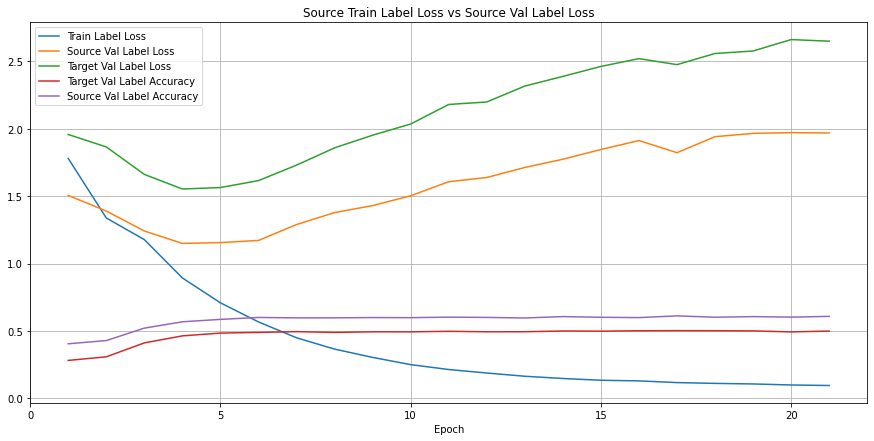

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

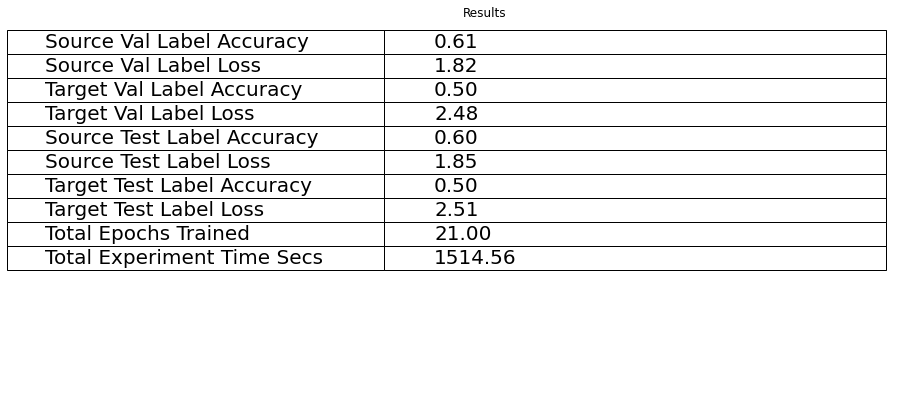

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

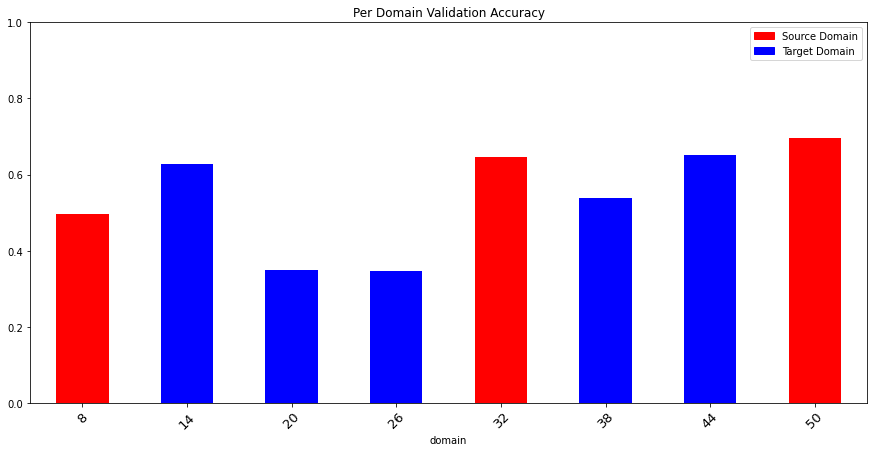

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.6025173611111111 Target Test Label Accuracy: 0.4956770833333333
Source Val Label Accuracy: 0.6120659722222223 Target Val Label Accuracy: 0.5025


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:oracle.run2_limited", "parameters": {"experiment_name": "tuned_1v2:oracle.run2_limited", "device": "cuda", "lr": 0.0001, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "episode_transforms_source": [], "episode_transforms_target": [], "domains_source": [8, 32, 50], "domains_target": [14, 20, 26, 38, 44], "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "n_shot": 3, "n_way": 16, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [